# Load raw dataset
A medium-sized dataset is provided (rather than 12 GB full dataset as is in AWS) for data wrangling in the spark cluster of IBM Watson Studio. 


In [1]:
# Load raw data to spark

import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-b314834d-5443-4359-8efa-88fb1ca94789',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'NfS0KqvIB-QZO6PoO6p1UYPdzthvM2t3mOeNGUatbbnC'
}

configuration_name = 'os_c4ce378e6d4243b4bee4d7f946ea0bff_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-crgpbxoft3rjye'))
df_data_1.take(5)

NameError: name 'sc' is not defined

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json('medium-sparkify-event-data.json')
df_data_1.take(5)

22/08/10 08:55:32 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.81 instead (on interface en0)
22/08/10 08:55:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/10 08:55:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Data cleanning and exploration 
In this section, data cleaning is completed including checking size of dataset, columns, invalid or missing data, drop duplicates, exploratory visualization, categorical data processing, and so forth. 

In [76]:
from pyspark.sql import Row
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df_data_1.show()

+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|      auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford| Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body| Logged In|   Sawyer|     M|           74|   Larson|380.21179|

In [6]:
print((df_data_1.count(), len(df_data_1.columns)))

(543705, 18)


In [7]:
df_data_1.select('page').distinct().show(100, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Login                    |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
|Submit Registration      |
|Register                 |
+-------------------------+



In [8]:
df_data_1.select('song').distinct().count()

80293

In [9]:
df_data_1.agg({'length': 'max'}).collect()[0]

Row(max(length)=3024.66567)

## 1. Create Churn column based on "page" column

In [10]:
cancel_set = ['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Downgrade', 'Cancellation Confirmation']
df_data_1 = df_data_1.withColumn('Churn', when(df_data_1.page.isin(cancel_set), 1).otherwise(0))
df_data_1.show()

+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|      auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|       Martin Orford| Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|    0|
|   John Brown's Body| Logged In|   Sawyer|     M|          

## 2. Remove invalid, missing, duplicate records
1. Intuitively, we do not think the leave or stay of a customer would be affected by his/her name and registration ID. So the columns "firstName", "lastName", and "registration" can be simply dropped.
2. Based on the aggregation results of groupBy('Churn', 'artist'), groupBy('Churn', 'song'), and column "length", all cases of Churn==1 have null artist, song, and length, so churn rate is also not related to them in this dataset. Here we drop columns "artist", "song", and "length" as well.
3. After dropping unused columns, we filter out rows with null value. 

In [11]:
# Count missing values for each column
df_data_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data_1.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+-----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|Churn|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+-----+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110829|     0|  0|    15700|     0|    0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+-----+



In [12]:
count_churn_0 = df_data_1.groupBy('Churn', 'artist').count().filter(df_data_1.Churn == 0)
count_churn_1 = df_data_1.groupBy('Churn', 'artist').count().filter(df_data_1.Churn == 1)
count_churn_0.show()
count_churn_1.show()

+-----+--------------------+-----+
|Churn|              artist|count|
+-----+--------------------+-----+
|    0|           The Kooks|  467|
|    0|             Bacilos|  121|
|    0|Brigitte Bardot /...|    7|
|    0|         Passion Pit|  345|
|    0|        Supersuckers|    8|
|    0|         Los Bunkers|   46|
|    0|               Opeth|  117|
|    0|         State Radio|   40|
|    0|                 Mud|   48|
|    0|Jack Johnson / Ka...|   21|
|    0|   Story Of The Year|  100|
|    0|    Peter And Gordon|   29|
|    0|    David Arkenstone|   24|
|    0|          Eskimo Joe|   30|
|    0|         Brian Regan|   17|
|    0|     Massive TÃÂ¶ne|    4|
|    0|       Elvis Presley|   33|
|    0|         Boney James|   57|
|    0|      The Fire Theft|   17|
|    0|Major Lazer / Vyb...|   16|
+-----+--------------------+-----+
only showing top 20 rows

+-----+------+-----+
|Churn|artist|count|
+-----+------+-----+
|    1|  null| 9037|
+-----+------+-----+



In [13]:
count_churn_0 = df_data_1.groupBy('Churn', 'song').count().filter(df_data_1.Churn == 0)
count_churn_1 = df_data_1.groupBy('Churn', 'song').count().filter(df_data_1.Churn == 1)
count_churn_0.show()
count_churn_1.show()

+-----+--------------------+-----+
|Churn|                song|count|
+-----+--------------------+-----+
|    0|               Reign|   10|
|    0|    Ne Me Quitte Pas|    2|
|    0|    Snow White Queen|    9|
|    0|            Auto-Dub|   15|
|    0|          Release Me|   20|
|    0|The Desperate Kin...|    3|
|    0|             Dragula|   29|
|    0|      Zamba de Usted|    1|
|    0|May The Words Of ...|    6|
|    0|I MÃÂ¶rkret Med Dej|   11|
|    0|Searching (So Muc...|    4|
|    0|Hypnotized (featu...|   24|
|    0|           Entertain|    6|
|    0|Diverse City (Wel...|    3|
|    0|My Drink (I Remem...|   14|
|    0|Machine Gun Funk ...|   19|
|    0|               Saxon|    5|
|    0|            Over You|   15|
|    0|Rubber & Soul (An...|    2|
|    0|          Fast-Track|   16|
+-----+--------------------+-----+
only showing top 20 rows

+-----+----+-----+
|Churn|song|count|
+-----+----+-----+
|    1|null| 9037|
+-----+----+-----+



In [14]:
count_churn_0 = df_data_1.filter(df_data_1.Churn == 0).select('length').show()
count_churn_1 = df_data_1.filter(df_data_1.Churn == 1).select('length').show()

+---------+
|   length|
+---------+
|597.55057|
|380.21179|
|202.37016|
|     null|
|194.53342|
|138.29179|
|     null|
|     null|
|     null|
|     null|
|     null|
|220.39465|
|     null|
|201.50812|
|357.66812|
|256.96608|
|164.23138|
|251.48036|
|     null|
|157.67465|
+---------+
only showing top 20 rows

+------+
|length|
+------+
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
|  null|
+------+
only showing top 20 rows



In [15]:
cols = ('artist' ,'firstName', 'lastName', 'length', 'song', 'registration')
df_drop = df_data_1.drop(*cols)
df_drop.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = false)



In [16]:
# Remove null records
df_drop = df_drop.na.drop()
df_drop.count()

528005

In [102]:
# Remove error records of column "page"
df_drop = df_drop.filter(df_drop.page != 'Error')

In [103]:
# Drop duplicates
# Drop page column because we already get dummy variables for this column 
df_cleaned = df_drop.drop_duplicates()
df_cleaned = df_cleaned.drop('page')
df_cleaned.count()

527502

## 3. Data exploration

In [19]:
df_cleaned.show()

+---------+------+-------------+-----+--------------------+------+---------+------+-------------+--------------------+------+-----+
|     auth|gender|itemInSession|level|            location|method|sessionId|status|           ts|           userAgent|userId|Churn|
+---------+------+-------------+-----+--------------------+------+---------+------+-------------+--------------------+------+-----+
|Logged In|     M|           17| free|New York-Newark-J...|   PUT|      485|   307|1538358281000|"Mozilla/5.0 (Mac...|   273|    0|
|Logged In|     M|           32| free|Dallas-Fort Worth...|   PUT|      497|   200|1538358545000|Mozilla/5.0 (Wind...|   100|    0|
|Logged In|     M|           27| free|New York-Newark-J...|   GET|      485|   200|1538359820000|"Mozilla/5.0 (Mac...|   273|    0|
|Logged In|     M|           76| free|  Corpus Christi, TX|   PUT|      292|   200|1538362379000|"Mozilla/5.0 (Mac...|   293|    0|
|Logged In|     F|           15| paid|Dallas-Fort Worth...|   GET|      418|

In [20]:
df_cleaned.filter(df_cleaned.Churn == 1).count()

9037

### 3.1 Check how userAgent and location relate to churn
The histogram of number of user agents and locations are consistent between churn 1 and churn 0, which demonstrates that churn behavior is also unrelated to these two factors. So we drop these two columns as well. 

In [104]:
df_1 = df_cleaned.groupBy('Churn', 'userAgent').count().filter(df_cleaned.Churn == 1).toPandas().rename(columns={"count": "count_1"})
df_0 = df_cleaned.groupBy('Churn', 'userAgent').count().filter(df_cleaned.Churn == 0).toPandas().rename(columns={"count": "count_0"})
df_combined = pd.concat([df_1['count_1'], df_0['count_0']], axis = 1)
df_combined['count_1'] = (df_combined['count_1'] - df_combined['count_1'].min()) / (df_combined['count_1'].max() - df_combined['count_1'].min())
df_combined['count_0'] = (df_combined['count_0'] - df_combined['count_0'].min()) / (df_combined['count_0'].max() - df_combined['count_0'].min())
df_combined.head()

,count_1,count_0
0,0.232915,0.038064
1,0.008368,0.077592
2,0.161785,0.206202
3,0.104603,0.039816
4,0.001395,0.012688


Text(0, 0.5, 'Frequency')

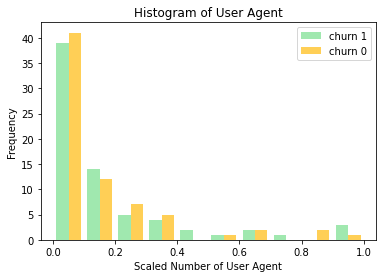

In [105]:
plt.hist(df_combined, color=['#A0E8AF', '#FFCF56'])
plt.legend(['churn 1', 'churn 0'])
plt.title('Histogram of User Agent')
plt.xlabel('Scaled Number of User Agent')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

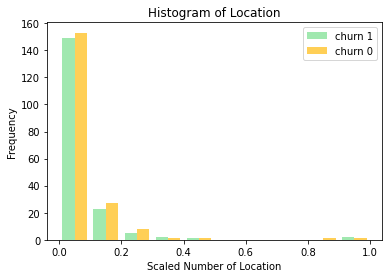

In [106]:
df_1 = df_cleaned.groupBy('Churn', 'location').count().filter(df_cleaned.Churn == 1).toPandas().rename(columns={"count": "count_1"})
df_0 = df_cleaned.groupBy('Churn', 'location').count().filter(df_cleaned.Churn == 0).toPandas().rename(columns={"count": "count_0"})
df_combined = pd.concat([df_1['count_1'], df_0['count_0']], axis = 1)
df_combined['count_1'] = (df_combined['count_1'] - df_combined['count_1'].min()) / (df_combined['count_1'].max() - df_combined['count_1'].min())
df_combined['count_0'] = (df_combined['count_0'] - df_combined['count_0'].min()) / (df_combined['count_0'].max() - df_combined['count_0'].min())

plt.hist(df_combined, color=['#A0E8AF', '#FFCF56'])
plt.legend(['churn 1', 'churn 0'])
plt.title('Histogram of Location')
plt.xlabel('Scaled Number of Location')
plt.ylabel('Frequency')

In [107]:
# Drop unused columns
df_cleaned = df_cleaned.drop('location', 'userAgent')
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|
|Logged In|     F|           15| paid|   GET|      418|   200|1538366282000|   127|    1|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|
|Logged In|     M|           64| free|   PUT|      249|   200|1538375165000|   250|    0|
|Logged In|     M|           19| free|   PUT|      529|   200|1538376380000|   207|    0|
|Logged In

### 3.2 Process date time

In [108]:
df_cleaned = df_cleaned.withColumn('date' ,from_unixtime(col('ts'), 'yyyy-MM-dd'))
df_cleaned = df_cleaned.withColumn('time', from_unixtime(col('ts'), "HH:mm:ss"))
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+------------+--------+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|        date|    time|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+------------+--------+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|+50718-08-20|12:43:20|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|+50718-08-23|14:03:20|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|+50718-09-07|08:13:20|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|+50718-10-06|23:03:20|
|Logged In|     F|           15| paid|   GET|      418|   200|1538366282000|   127|    1|+50718-11-21|02:13:20|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|+50718-12-11|03

In [109]:
# It is meaningful to study churn behavior by day of week, but we cannot get correct date format based on timestamp in the ts column, so we don't use date in this project
# It might be useful to study hourly churn behavior but not on minute or second basis
df_cleaned = df_cleaned.withColumn('hours', split(df_cleaned['time'], ':').getItem(0))

# Drop the columns not to use
df_cleaned = df_cleaned.drop('date', 'time')
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+-----+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|hours|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+-----+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|   12|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|   14|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|   08|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|   23|
|Logged In|     F|           15| paid|   GET|      418|   200|1538366282000|   127|    1|   02|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|   03|
|Logged In|     M|           64| free|   PUT|      249|   200|1538375165000|   250|    0|   21|
|Logged In|     M|           19| free|  

/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<AxesSubplot:xlabel='auth', ylabel='Churn'>

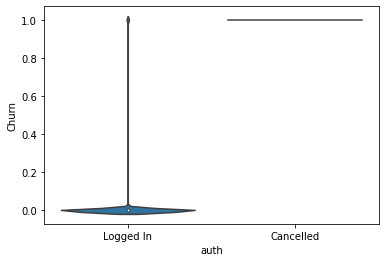

22/08/10 20:45:44 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 4785518 ms exceeds timeout 120000 ms
22/08/10 20:45:44 WARN SparkContext: Killing executors is not supported by current scheduler.
22/08/11 09:09:55 WARN TransportChannelHandler: Exception in connection from /192.168.0.81:52121
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel

In [126]:
df_cleaned_df = ps.DataFrame(df_cleaned).to_pandas()
sns.violinplot(x = 'auth', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='gender', ylabel='Churn'>

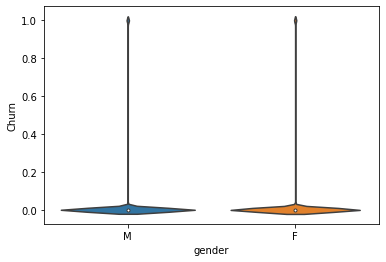

In [127]:
sns.violinplot(x = 'gender', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='level', ylabel='Churn'>

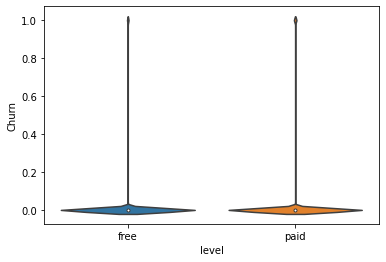

In [128]:
sns.violinplot(x = 'level', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='method', ylabel='Churn'>

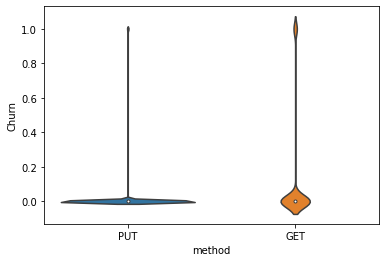

In [129]:
sns.violinplot(x = 'method', y = 'Churn', data = df_cleaned_df)

The violinplots above demonstrate that gender and level have little impact on churn, while auth and method may be more related. So we drop the columns "gender" and "level".

In [131]:
df_cleaned = df_cleaned.drop('gender', 'level')
df_cleaned.show()

+---------+-------------+------+---------+------+-------------+------+-----+-----+
|     auth|itemInSession|method|sessionId|status|           ts|userId|Churn|hours|
+---------+-------------+------+---------+------+-------------+------+-----+-----+
|Logged In|           17|   PUT|      485|   307|1538358281000|   273|    0|   12|
|Logged In|           32|   PUT|      497|   200|1538358545000|   100|    0|   14|
|Logged In|           27|   GET|      485|   200|1538359820000|   273|    0|   08|
|Logged In|           76|   PUT|      292|   200|1538362379000|   293|    0|   23|
|Logged In|           15|   GET|      418|   200|1538366282000|   127|    1|   02|
|Logged In|           11|   PUT|      487|   200|1538368016000|   131|    0|   03|
|Logged In|           64|   PUT|      249|   200|1538375165000|   250|    0|   21|
|Logged In|           19|   PUT|      529|   200|1538376380000|   207|    0|   00|
|Logged In|          317|   PUT|      178|   307|1538378914000|   179|    0|   08|
|Log

### 3.3 Process categorical variables

In [132]:
df_cleaned = df_cleaned.withColumn('method_num', when(df_cleaned.method == 'PUT', 1).otherwise(0)).drop('method', 'ts')
df_cleaned = df_cleaned.withColumn('auth_num', when(df_cleaned.auth == 'Cancelled', 1).otherwise(0)).drop('auth')
df_cleaned.show()

+-------------+---------+------+------+-----+-----+----------+--------+
|itemInSession|sessionId|status|userId|Churn|hours|method_num|auth_num|
+-------------+---------+------+------+-----+-----+----------+--------+
|           17|      485|   307|   273|    0|   12|         1|       0|
|           32|      497|   200|   100|    0|   14|         1|       0|
|           27|      485|   200|   273|    0|   08|         0|       0|
|           76|      292|   200|   293|    0|   23|         1|       0|
|           15|      418|   200|   127|    1|   02|         0|       0|
|           11|      487|   200|   131|    0|   03|         1|       0|
|           64|      249|   200|   250|    0|   21|         1|       0|
|           19|      529|   200|   207|    0|   00|         1|       0|
|          317|      178|   307|   179|    0|   08|         1|       0|
|           37|      493|   200|    51|    0|   03|         1|       0|
|          119|       27|   200|    28|    0|   06|         0|  

In [156]:
df_cleaned_ps = ps.DataFrame(df_cleaned)
df_cleaned_ps['userId'] = df_cleaned_ps['userId'].astype(int)
df_cleaned_ps['hours'] = df_cleaned_ps['hours'].astype(int)
df_cleaned_ps.dtypes

itemInSession    int64
sessionId        int64
status           int64
userId           int64
Churn            int32
hours            int64
method_num       int32
auth_num         int32
dtype: object

### Important notes
Based on the heatmapping result below, there are three features related to churn rate, namely status, method, and auth. We remove those unrelated. 

/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<AxesSubplot:>

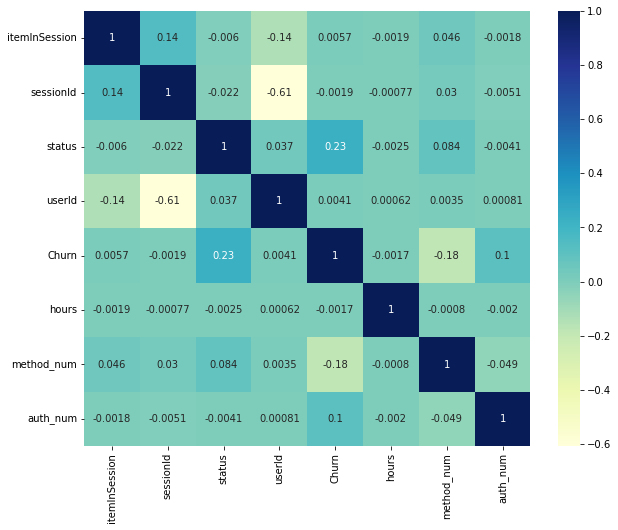

In [158]:
data_corr = df_cleaned_ps.to_pandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, cmap="YlGnBu", annot=True, xticklabels=True)

In [160]:
df_cleaned_ps = df_cleaned_ps.drop(['itemInSession', 'sessionId', 'userId', 'hours'], axis = 1)
df_cleaned_ps.head()

,status,Churn,method_num,auth_num
0,307,0,1,0
1,200,0,1,0
2,200,0,0,0
3,200,0,1,0
4,200,1,0,0


### 3.4 Save the processed data for modeling later

In [186]:
df_cleaned_df = df_cleaned_ps.to_pandas()
df_cleaned_df.to_json('churn_modeling_data.json', orient='records')

/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [195]:
df_cleaned_df[df_cleaned_df.Churn == 1].shape[0] / df_cleaned_df.shape[0]

0.017131688600232797

# Modeling to predict Churn rate

## 1. Load training data

In [208]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.inspection import permutation_importance

In [198]:
data = spark.read.json('churn_modeling_data.json')
data.show()

+-----+--------+----------+------+
|Churn|auth_num|method_num|status|
+-----+--------+----------+------+
|    0|       0|         1|   307|
|    0|       0|         1|   200|
|    0|       0|         0|   200|
|    0|       0|         1|   200|
|    1|       0|         0|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   307|
|    0|       0|         1|   200|
|    0|       0|         0|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         0|   200|
|    0|       0|         1|   307|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
|    0|       0|         1|   200|
+-----+--------+----------+------+
only showing top 20 rows



## 2. Train the model

In [210]:
# Split training data into training and validation sets
train, test = data.randomSplit([0.9, 0.1], seed=42)
train.show()

+-----+--------+----------+------+
|Churn|auth_num|method_num|status|
+-----+--------+----------+------+
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
|    0|       0|         0|   200|
+-----+--------+----------+------+
only showing top 20 rows



In [209]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0.0)
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1]).addGrid(lr.elasticNetParam, [0.0, 1.0]).build()

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds=10)

cvModel = crossval.fit(train)

results = cvModel.transform(test)

cvModel.avgMetrics

IllegalArgumentException: features does not exist. Available: Churn, auth_num, method_num, status, CrossValidator_1c306efc5e25_rand